In [72]:
# Descomentar para actualizar librerias
# Si se actualiza alguna libreria hay que reiniciar el notebook
#!pip install numpy --upgrade --user --quiet
#!pip install pandas --upgrade --user --quiet
#!pip install scipy --upgrade --user --quiet
#!pip install statsmodels --upgrade --user --quiet
#!pip install scikit-learn --upgrade --user --quiet
#!pip install missingno --upgrade --user --quiet
#!pip install apafib --upgrade --user --quiet
!pip install yellowbrick

In [73]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# Cargamos todas las libreriras y nuestro DataFrame

Para la posterior graficacion añadiremos la libreria Pandas, matplotlib y seaborn


In [74]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

Añadimos el conjunto de datos al problema desde la libreria apafib

In [75]:
from apafib import load_BCN_IBEX
IBEX = load_BCN_IBEX()
IBEX.head()

,Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges,Dades meteorològiques: Precipitació / Barcelona - Zona Universitària,Dades meteorològiques: Temperatura / Barcelona - Zona Universitària,Dades meteorològiques: Vent / Barcelona - Zona Universitària,Estat del trànsit segons trams horaris / Matí (6-13),Estat del trànsit segons trams horaris / Nit (0-5),Estat del trànsit segons trams horaris / Tarda (14-19),Estat del trànsit segons trams horaris / Vespre (20-24),IPC interanual / Barcelona,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Amèrica,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Espanya,Operacions d'aeronaus a l'aeroport de Barcelona-El Prat segons origen/destinació / Europa,Preu electricitat (majorista) /,Matriculacions de vehicles a Barcelona / Turismes,Mercat bursàtil: IBEX-35 /
0,115.0,0.0,8.01,5.61,1.331,1.132,1.357,1.293,0.5,3.0,82.0,64.0,42.510,0.0,8079.0
1,115.0,0.0,5.96,6.51,1.519,1.309,1.581,1.375,0.5,3.0,106.0,87.0,48.720,0.0,8079.0
2,115.0,0.0,5.31,5.52,1.398,1.189,1.474,1.331,0.5,2.0,138.0,134.0,46.928,0.0,8079.0
3,115.0,0.0,5.72,5.13,1.866,1.200,1.960,1.510,0.5,3.0,149.0,114.0,59.850,21.0,8079.0
4,115.0,0.0,5.23,4.25,1.880,1.221,1.923,1.446,0.5,1.0,103.0,81.0,67.545,54.0,8062.9


Los nombres de las variables son bastante largos y con caracteres especiales asi que los vamos a modificar

In [76]:
new_var_name = ['Compra_Venta','Precipitacio','Temperatura','Vent','Transit_Mati','Transit_Nit','Transit_Tarda','Transit_Vespre','IPC','Vols_America','Vols_Espanya','Vols_Europa','Preu_Electricitat','Matriculacions','Valor_IBEX']
IBEX.columns = new_var_name

Ahora podemos empezar a usar graficos para ver mejor la distribución de las variables

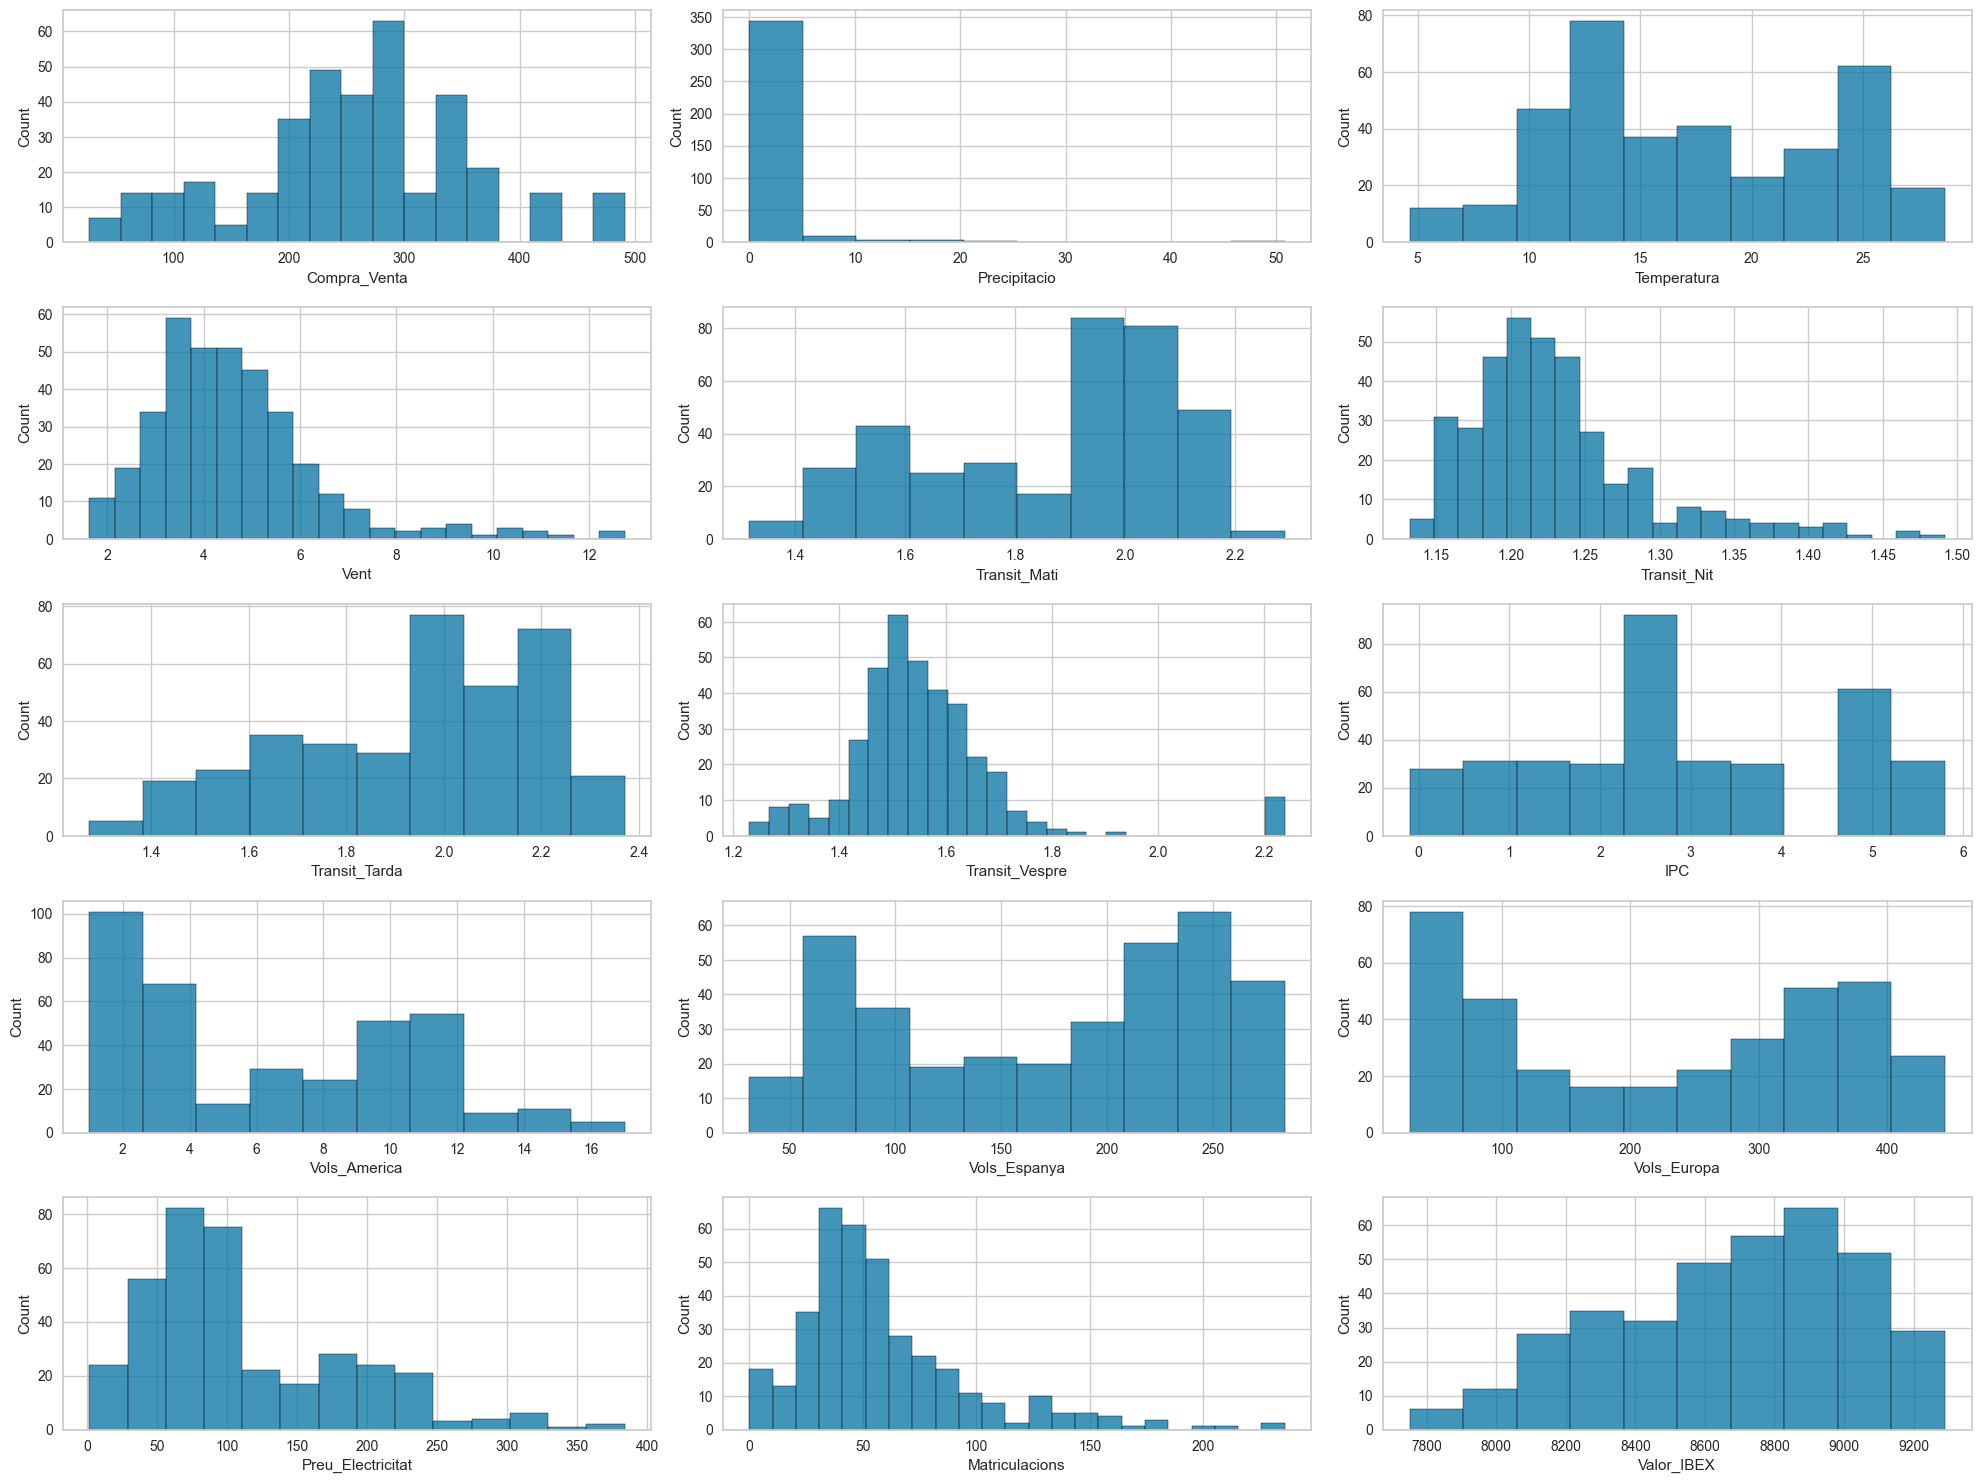

In [77]:
fig, axes = plt.subplots(5, 3, figsize=(20, 15))

IBEX_frame = pd.DataFrame(IBEX)
IBEX_frame.columns = IBEX.columns

for i, c in enumerate(IBEX.columns):
    ax = axes.reshape(-1)[i]
    if IBEX_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c, data=IBEX_frame, ax=ax)
    else:
        b = sns.histplot(x=c, data=IBEX_frame, ax=ax)

plt.tight_layout()



Vemos que solo hay variable que siga una distribución Gausiana que es "Compra-Venda d'habitatges a Barcelona (Nombre de transmissions) / Habitatges", por lo tanto no podemos esperar mucha informacion de los modelos lineales.

### Division del DataFrame
Dividiremos el conjunto de datos del problema 80% de entranamiento y 20% de test, de forma aleatoria y con una semilla fija para poder replicar el resultado

In [78]:
X= IBEX.iloc[:,:-1]
y= IBEX.loc[:,'Valor_IBEX'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Analisis de los datos del conjunto

Podriamos hacer una reducción de la dimensionalidad de los datos antes de la exploración, pero para este problema en concreto creo que es mas adecuado hacerlo despues de un primer analisis para asi entender los datos de forma original. Por ejemplo, quizas después de este primer analisas se pueden descartar variables antes si quiera de reducirlas.

Por lo tantoHacemos un primer pequeño resumen estadistico de las variables numericas

In [79]:
IBEX.describe()

,Compra_Venta,Precipitacio,Temperatura,Vent,Transit_Mati,Transit_Nit,Transit_Tarda,Transit_Vespre,IPC,Vols_America,Vols_Espanya,Vols_Europa,Preu_Electricitat,Matriculacions,Valor_IBEX
count,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000,365.000
mean,258.921,0.928,17.186,4.624,1.865,1.231,1.943,1.557,2.735,6.277,172.274,223.775,111.926,59.203,8679.076
std,99.043,4.057,6.034,1.755,0.226,0.061,0.253,0.160,1.739,4.246,75.920,135.202,72.460,38.921,347.513
min,27.000,0.000,4.640,1.630,1.317,1.132,1.273,1.230,-0.100,1.000,31.000,28.000,1.420,0.000,7750.200
25%,210.000,0.000,12.360,3.450,1.657,1.191,1.736,1.475,1.800,2.000,94.000,78.000,61.392,35.000,8397.700
50%,266.000,0.000,16.360,4.330,1.956,1.218,2.000,1.536,2.500,6.000,192.000,243.000,88.952,51.000,8753.300
75%,310.000,0.000,23.460,5.390,2.036,1.251,2.152,1.612,4.900,10.000,243.000,350.000,159.368,73.000,8957.200
max,491.000,50.800,28.660,12.730,2.290,1.492,2.371,2.238,5.800,17.000,284.000,445.000,383.673,236.000,9289.900


Para entender la relacion entre las variables usaremos una matriz de correlacion

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

<Axes: >

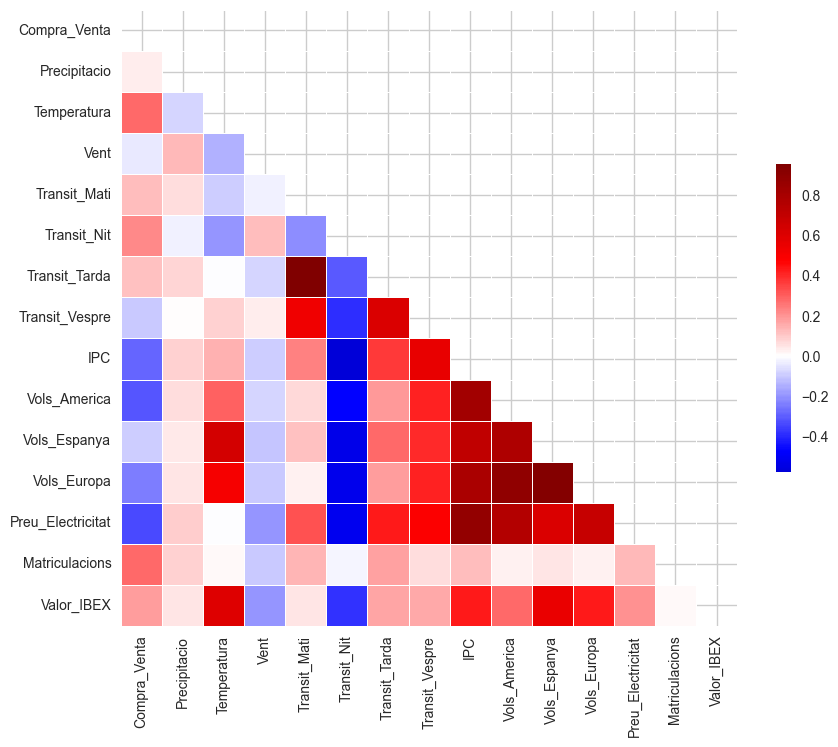

In [80]:
corr = IBEX.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


Con esta información podemos analizar que variables tienen más correlacion con la variable objetivo. La correlacion de variables independientes nos puede dar una primera indicación de que variables afectan al valor objetivo. Per exemple dades com la temperatura, l'IPC i les operacions d'aeronaus al aeroport de Barcelona podrien tindre certa relació amb el valor bursàtil del IBEX. 

En cambio, el viento y el estado del trafico por la noche parece tener muy poca correlacion con la variable objetivo. Aun asi, para excluirlas del problema deberemos hacer un estudio mas detallado ya que la correlacion solo captura la relación lineal, pueden haber relaciones no lineales o complejas que no se esten viendo reflejadas.

Con esta información continuamos el analisis teniendo estos hechos en cuenta.

## Transformación de variables
### Recodificación

Como luego usaremos modelos (Lineal, Lasso y Ridge) que no aceptan variables categoricas habria que transformarlas. Aun asi, no es necesaria la recodificación ya que no tenemos variables categóricas.

### Valores perdidos

Al igual que con la recodificacion, no hace falta ajustar los valores perdidos ya que nuestro dataFrame no tiene.

### Transformacion logaritmica

Dada la baja correlacion de la variable objetivo con las variables precipitacion, viento, trafico y matriculaciones noche vamos a ver si tienen una relacion exponencial. Esto lo haremos 

Text(0.5, 0.98, 'Comparación de Gráficos de Dispersión')

Text(0.5, 0, 'Precipitacio')

Text(0, 0.5, 'Valor_IBEX')

Text(0.5, 1.0, 'Sin Transformación: Precipitacio vs. Valor_IBEX')

Text(0.5, 0, 'log(Precipitacio)')

Text(0, 0.5, 'log(Valor_IBEX)')

Text(0.5, 1.0, 'Con Transformación Logarítmica: log(Precipitacio) vs. log(Valor_IBEX)')

Text(0.5, 0, 'Vent')

Text(0, 0.5, 'Valor_IBEX')

Text(0.5, 1.0, 'Sin Transformación: Vent vs. Valor_IBEX')

Text(0.5, 0, 'log(Vent)')

Text(0, 0.5, 'log(Valor_IBEX)')

Text(0.5, 1.0, 'Con Transformación Logarítmica: log(Vent) vs. log(Valor_IBEX)')

Text(0.5, 0, 'Transit_Nit')

Text(0, 0.5, 'Valor_IBEX')

Text(0.5, 1.0, 'Sin Transformación: Transit_Nit vs. Valor_IBEX')

Text(0.5, 0, 'log(Transit_Nit)')

Text(0, 0.5, 'log(Valor_IBEX)')

Text(0.5, 1.0, 'Con Transformación Logarítmica: log(Transit_Nit) vs. log(Valor_IBEX)')

Text(0.5, 0, 'Matriculacions')

Text(0, 0.5, 'Valor_IBEX')

Text(0.5, 1.0, 'Sin Transformación: Matriculacions vs. Valor_IBEX')

Text(0.5, 0, 'log(Matriculacions)')

Text(0, 0.5, 'log(Valor_IBEX)')

Text(0.5, 1.0, 'Con Transformación Logarítmica: log(Matriculacions) vs. log(Valor_IBEX)')

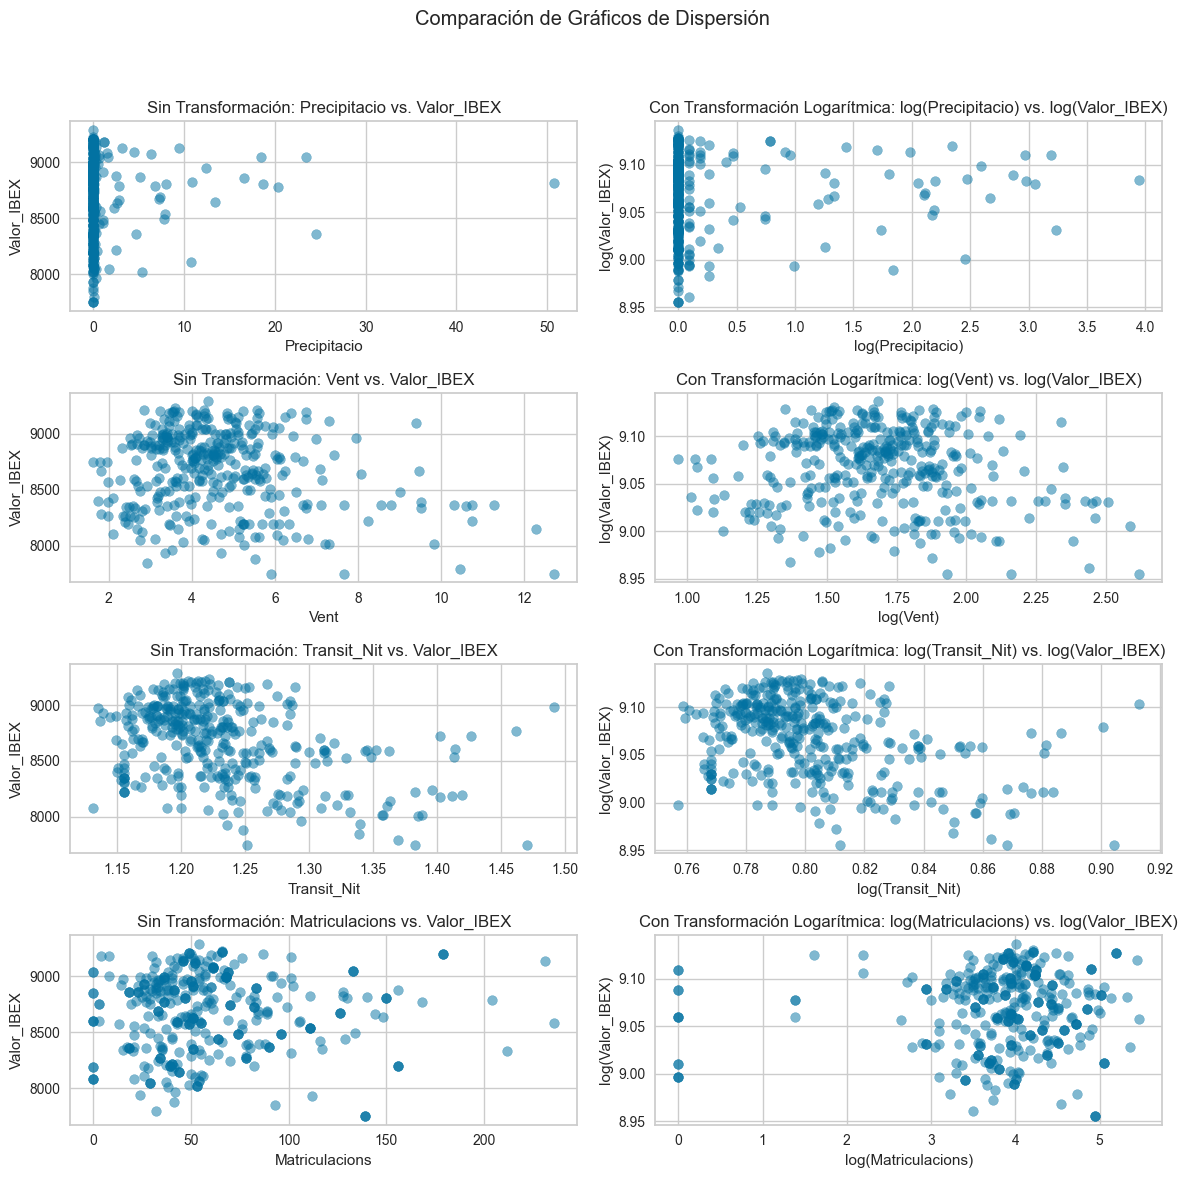

In [81]:

fig, axes = plt.subplots(4, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Comparación de Gráficos de Dispersión')


variables = ["Precipitacio", "Vent", "Transit_Nit", "Matriculacions"]
target_variable = "Valor_IBEX"

for i, variable in enumerate(variables):

    axes[i, 0].scatter(IBEX[variable], IBEX[target_variable], alpha=0.5)
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel(target_variable)
    axes[i, 0].set_title(f'Sin Transformación: {variable} vs. {target_variable}')

    IBEX[f'{variable}_log'] = np.log(IBEX[variable] + 1) 
    IBEX[f'{target_variable}_log'] = np.log(IBEX[target_variable])
    axes[i, 1].scatter(IBEX[f'{variable}_log'], IBEX[f'{target_variable}_log'], alpha=0.5)
    axes[i, 1].set_xlabel(f'log({variable})')
    axes[i, 1].set_ylabel(f'log({target_variable})')
    axes[i, 1].set_title(f'Con Transformación Logarítmica: log({variable}) vs. log({target_variable})')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Como podemos ver, los graficos son practicamente los mismos, por lo tanto las relaciones de estas variables no son exponenciales, aun quedaria la posibilidad de relaciones mas complejas o una relacion polinomica.

Por lo tanto no seria necesaria esta transformacion tampoco.

### Estandarizacion

Por ultimo si estandarizaremos lo datos ya que posteriormente aplicaremos un PCA y asi nos aseguramos que todas las caracteristicas tengan la misma escala

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)




## Análisis de Componentes Principales (PCA)

Vamos a emplear el método de Análisis de Componentes Principales (PCA) con el objetivo de evaluar si es factible disminuir la complejidad del problema al disminuir el número de dimensiones, sin comprometer significativamente la cantidad de información representada.

<Figure size 1000x800 with 0 Axes>

Text(0.5, 0, 'Componente Principal 1')

Text(0, 0.5, 'Componente Principal 2')

Text(0.5, 1.0, 'Visualización PCA en 2D con Variable Objetivo')

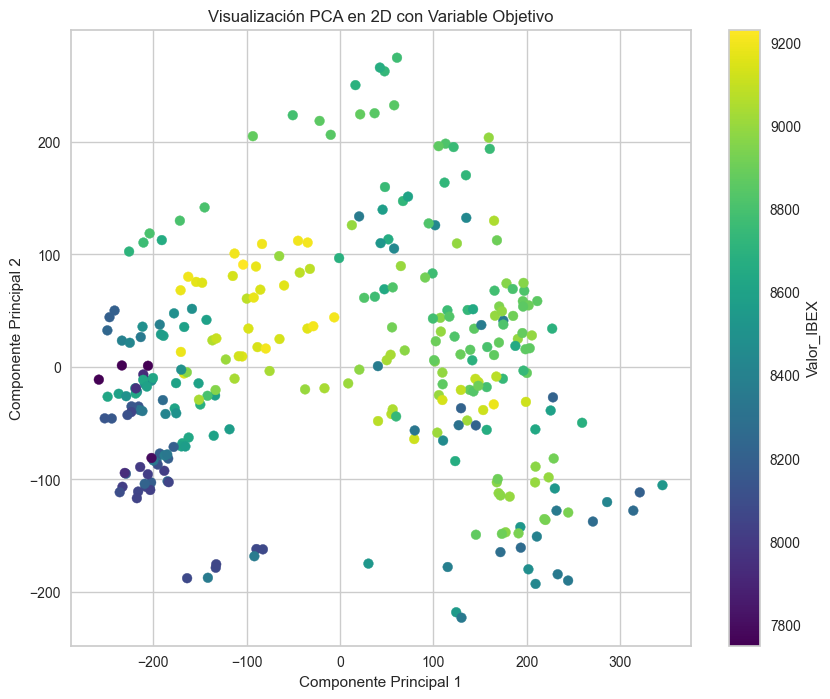

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_train)

pca_df = pd.DataFrame(data={'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'Valor_IBEX': y_train})

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Valor_IBEX'], cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización PCA en 2D con Variable Objetivo')
plt.colorbar(scatter, label='Valor_IBEX')
plt.grid(True)
plt.show()

Podemos observar cumulos de datos que, más o menos, se separan por valores, de todas formas, hay muchas zonas donde no se acaban de separar los puntos, seguramente mas dimensiones ayudarian a aclarar la confusión

Por lo tanto sí, es posible que exista una relación entre las variables del conjunto de datos y la variable objetivo. Estos cúmulos sugieren que las variables del conjunto de datos pueden influir en la variable objetivo de alguna manera.

Sin embargo, también es importante remarcar, como hemos dicho ya, que existen áreas en el gráfico donde los puntos no se separan claramente y hay cierta superposición entre las clases de la variable objetivo. Esto indica que la relación no es completamente lineal ni perfectamente discriminativa, lo que podría ser el resultado de que la relacion de las variables con la variable objetivo sea compleja o por lo contrario que no haya relacion.

Por lo tanto, aunque hay indicios de una relación entre las variables del conjunto de datos y la variable objetivo, no es en absoluto concluyente hasta que hagamos mas analisis

## Regresiones
Importamos las librerias para las diferentes regresiones

In [84]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

### Regresion Lineal

In [85]:
lr = LinearRegression().fit(X_train,y_train)
r2_lr = np.mean(cross_val_score(lr.fit(X_train,y_train),X_train,y_train))

r2_results = pd.DataFrame({'lr':r2_lr},index=['CV R2'])
r2_results.loc['Test R2', :] =[r2_score(y_test,lr.predict(X_test))]
r2_results.loc['lambda','lr']=0
r2_results

,lr
CV R2,0.672
Test R2,0.639
lambda,0.000


### Regresion RIDGE

In [86]:
lambdas = [1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)

r2_ridge = np.mean(cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='r2'))

r2_results = pd.DataFrame({'RidgeRegression':r2_ridge},index=['CV R2'])
r2_results.loc['Test R2', :] =[r2_score(y_test,ridge_cv.predict(X_test))]
r2_results.loc['lambda','RidgeRegression']=10
r2_results

,RidgeRegression
CV R2,0.671
Test R2,0.640
lambda,10.000


### Regresion LASSO

In [87]:
lasso_cv =LassoCV(alphas=lambdas,cv=5,tol=1e-1).fit(X_train,y_train)
r2_lasso =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

r2_results = pd.DataFrame({'LASSO':r2_lasso},index=['CV R2'])
r2_results.loc['Test R2', :] =[r2_score(y_test,lasso_cv.predict(X_test))]
r2_results.loc['lambda','LASSO']=lasso_cv.alpha_
r2_results

,LASSO
CV R2,0.672
Test R2,0.640
lambda,0.010


### Analisis de los resultados de las regresiones

Para poder analizar los resultados y representar como difieren los valores predicho de los datos del test haremos los qqplots de cada uno

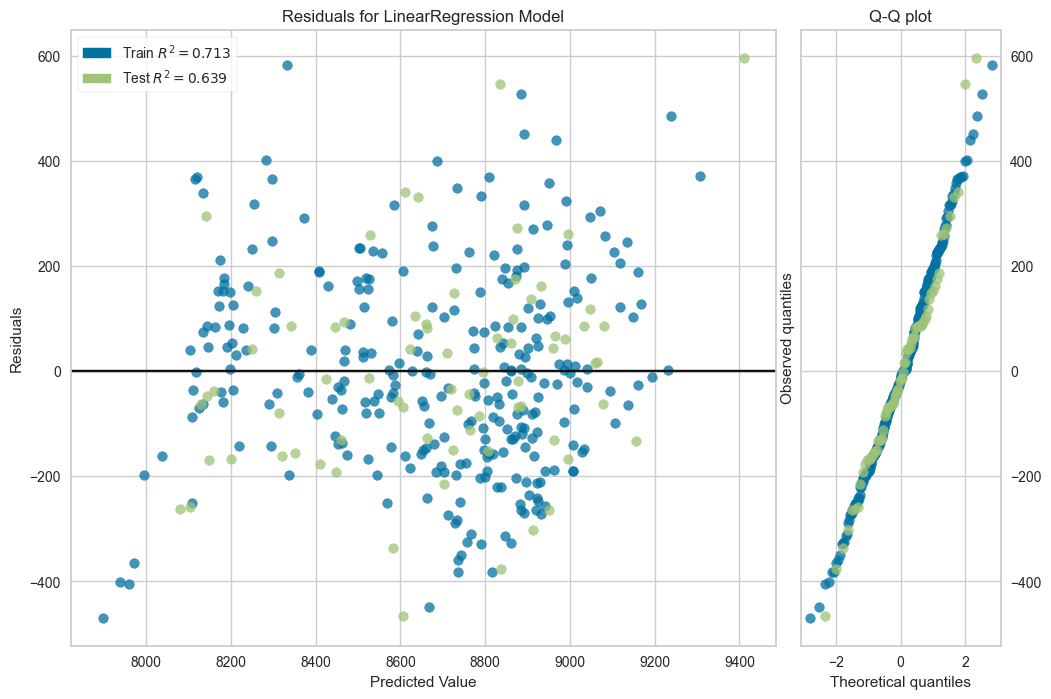

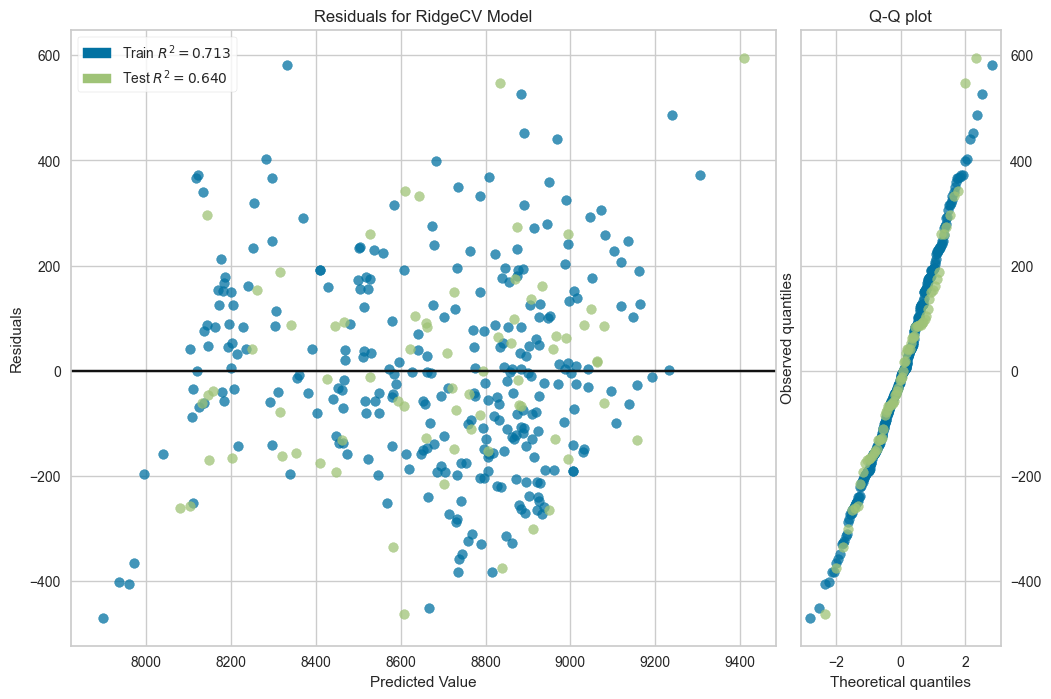

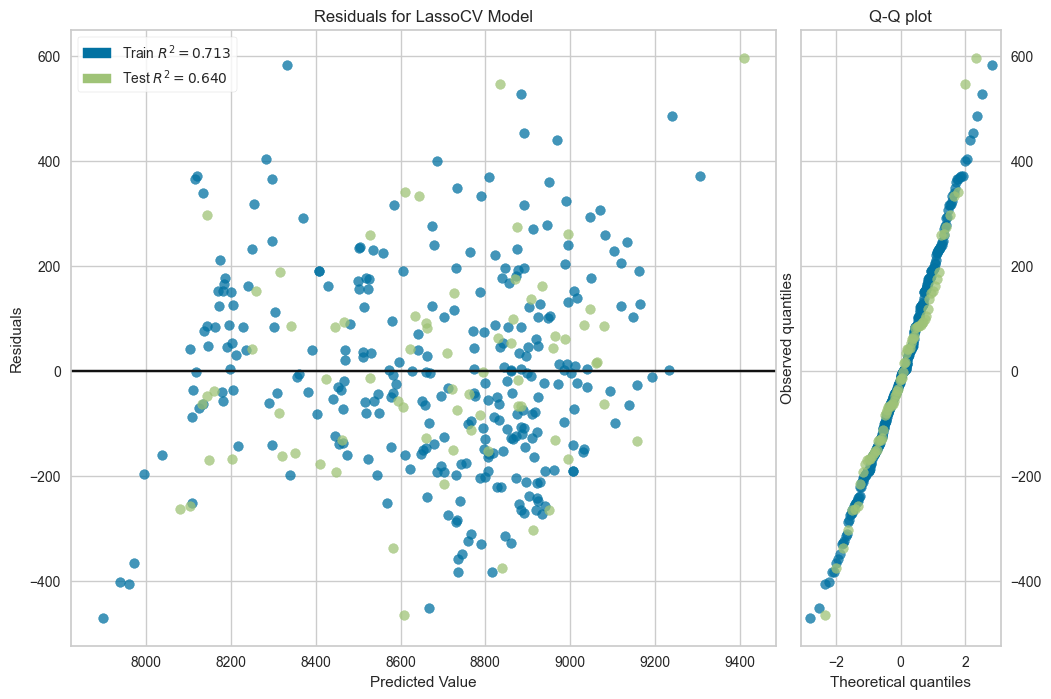

In [88]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8))
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)
plt.figure(figsize=(12,8))
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)
plt.figure(figsize=(12,8))
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False)

Como vemos, para nuestros datos los 3 modelos dan casi resultados identicos, por lo tanto no podemos concluir que modelo es mejor.

Analizaremos mas en profundidad las elecciones que han hecho los modelos viendo que pesos han asignado a cada variable cada modelo.

In [89]:
pesos = pd.DataFrame({'Lr':lr.coef_, 'LASSO':lasso_cv.coef_, 'Ridge': ridge_cv.coef_},index=X_train.columns)
pesos.T

,Compra_Venta,Precipitacio,Temperatura,Vent,Transit_Mati,Transit_Nit,Transit_Tarda,Transit_Vespre,IPC,Vols_America,Vols_Espanya,Vols_Europa,Preu_Electricitat,Matriculacions
Lr,0.169,11.305,31.368,-23.173,-774.694,-570.915,773.973,-518.640,235.859,-4.958,2.853,-2.726,-2.114,-1.214
LASSO,0.169,11.305,31.338,-23.237,-767.741,-567.106,766.893,-517.021,235.924,-4.992,2.860,-2.726,-2.114,-1.213
Ridge,0.169,11.309,31.298,-23.336,-756.383,-563.667,755.586,-515.257,236.077,-5.058,2.868,-2.726,-2.116,-1.212


Añadimos una visualizacion

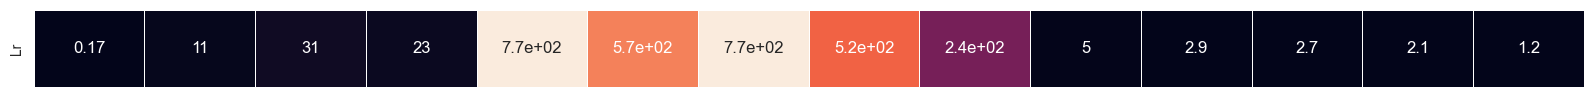

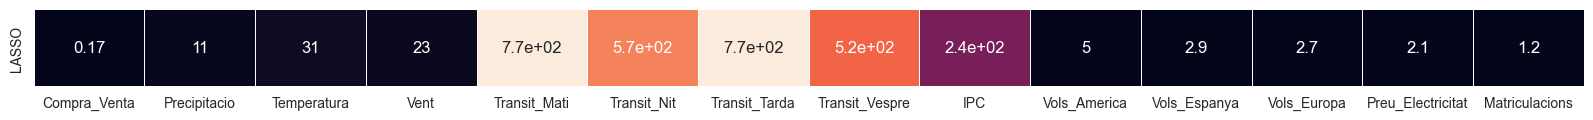

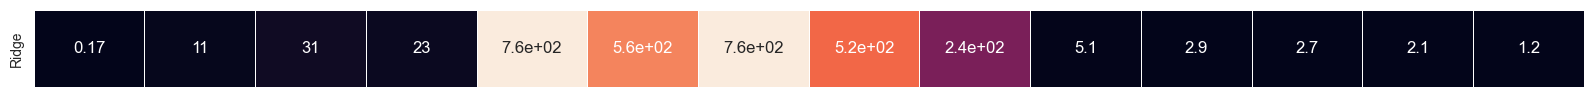

In [90]:
fig,  ax = plt.subplots( figsize = (20,1))
sns.heatmap(pesos.T.loc[['Lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(pesos.T.loc[['LASSO'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True)

plt.figure(figsize = (20,1))
sns.heatmap(pesos.T.loc[['Ridge'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False)

Vemos que los tres modelos dan practicame los mismos pesos a las variables. Podemos dividir los pesos en los menores de 5, los de entre 10 y 30 y luego los 5 pesos mas grandes superiores a los 240.

Las variables que los 3 modelos destacan no parece tener ninguna relación con la variables que queremos predecir, al menos el trafico no deberia tener relacion. La unica variable que podria tener sentido seria el IPC. Tambien, los 3 modelos, dan pesos bajos a la compra venta de inmuebles, al precio de la electricidad y las matriculaciones lo que en un principio me parecio que podria tener cierta relevacia por la influencia que estos tienen a la economia (o mejor dicho, que podrian ser indicadores de esta).

Eliminaremos las variables del grupo de pesos de menos de 5 y reajustaremos los modelos

### Eliminacion variables

In [91]:
X_train = X_train.drop(columns=["Compra_Venta",'Vols_America','Vols_Espanya', 'Vols_Europa','Preu_Electricitat','Matriculacions'])

X_test = X_test.drop(columns=["Compra_Venta",'Vols_America','Vols_Espanya', 'Vols_Europa','Preu_Electricitat','Matriculacions'])

Reajustamos lo modelos

In [92]:
lr = LinearRegression().fit(X_train,y_train)
r2_lr = np.mean(cross_val_score(lr.fit(X_train,y_train),X_train,y_train))

lasso_cv =LassoCV(alphas=lambdas,cv=5,tol=1e-1).fit(X_train,y_train)
r2_lasso =  np.mean(cross_val_score(lasso_cv, X_train,y_train))


lambdas = [1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
r2_ridge = np.mean(cross_val_score(ridge_cv, X_train, y_train, cv=5, scoring='r2'))

r2_results = pd.DataFrame({'Lr':r2_lr, 'LASSO':r2_lasso, 'Ridge':r2_ridge},index=['CV R2'])

r2_results.loc['Test R2', :] =[r2_score(y_test,lr.predict(X_test)),
                                r2_score(y_test,ridge_cv.predict(X_test)),
                                r2_score(y_test,lasso_cv.predict(X_test))]
r2_results.loc['lambda','Lr']='N/A'
r2_results.loc['lambda','LASSO']=lasso_cv.alpha_
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results


,Lr,LASSO,Ridge
CV R2,0.506,0.506,0.505
Test R2,0.423,0.423,0.423
lambda,N/A,0.001,0.001


Como podemos ver claramente, los resultados han empeorado

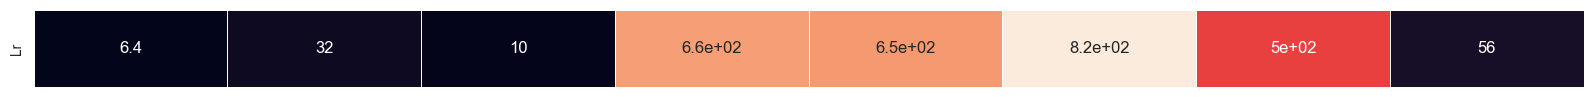

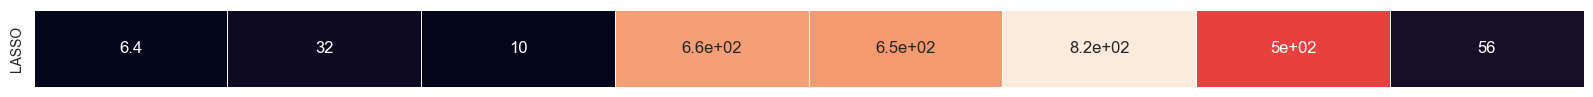

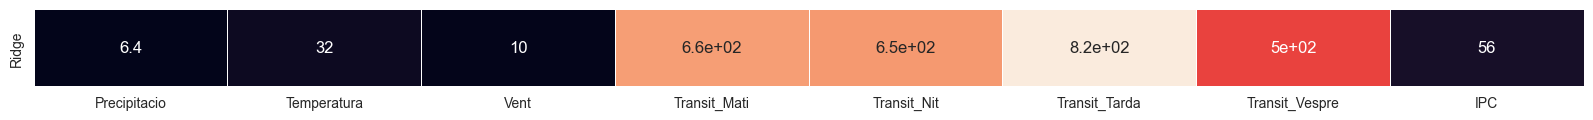

In [93]:
weights = pd.DataFrame({'Lr':lr.coef_, 'LASSO':lasso_cv.coef_, 'Ridge': ridge_cv.coef_},index=X_train.columns)
fig,  ax = plt.subplots( figsize = (20,1))
sns.heatmap(weights.T.loc[['Lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['LASSO'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True)

Los pesos se han mantenido mas o menos iguales, lo que si me ha sorprendido es que en todos los modelos, el IPC ha perdido mucho peso

## Relaciones Polinomicas

Como he explicado al principio, pueden haber relaciones mas complejas que las completamente lineales y no lineales, como he comentado anteriormente, los 
modelos han dado pesos bajos a variables que personalmente hubiese pensado que si tendrian mas relevancia.

Por lo tanto, vamos a intentar ver si efectivamente no hay relacion entre estas variables y la variable objetivo o quizas este relacion es polinomica.

Esto solo es posible para los modelos LASSO y Ridge

In [94]:
from sklearn.preprocessing import PolynomialFeatures    
import warnings
warnings.filterwarnings('ignore')

t = PolynomialFeatures(degree=2)
d = t.fit_transform(X_train)
f = t.transform(X_test)

lasso_cv =LassoCV(alphas=lambdas,cv=5,tol=1e-1).fit(d,y_train)
r2_lasso =  np.mean(cross_val_score(lasso_cv, d,y_train))

ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(d, y_train)
r2_ridge = np.mean(cross_val_score(ridge_cv, d, y_train, cv=5, scoring='r2'))

r2_results = pd.DataFrame({'LASSO':r2_lasso, 'Ridge': r2_ridge},index=['CV R2'])
r2_results.loc['Test R2', :] =[r2_score(y_test,ridge_cv.predict(f)),
                                r2_score(y_test,lasso_cv.predict(f))]
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','LASSO']=lasso_cv.alpha_
r2_results

,LASSO,Ridge
CV R2,0.646,0.639
Test R2,0.539,0.520
lambda,1.000,10.000


<Figure size 2000x100 with 0 Axes>

<Axes: >

<Figure size 2000x100 with 0 Axes>

<Axes: >

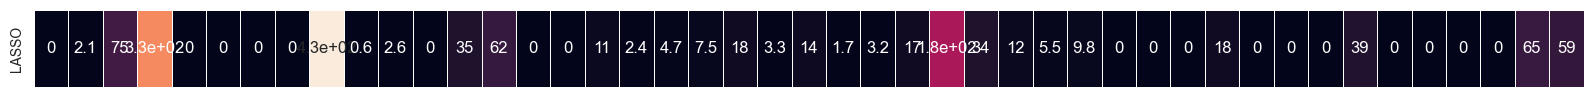

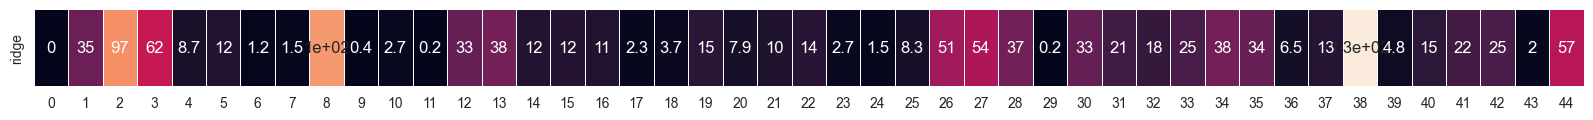

In [95]:
weights = pd.DataFrame({'LASSO':lasso_cv.coef_, 'ridge': ridge_cv.coef_},index=range(len(lasso_cv.coef_)))


plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['LASSO'],:].abs().round(1),annot=True, linewidths=.5,cbar=False,xticklabels=False)

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['ridge'],:].abs().round(1),annot=True, linewidths=.5,cbar=False,xticklabels=True)

Como podemos ver el resultado a mejorado respecto a la elimincacion de variables a las que se les habia dado menor peso pero ha empeorado ligeramente a los primeros resultados. Por lo tanto podriamos concluir que efectivamente es muy probable que los diferentes datos contemplados en el DataFrame sobre Barcelona no tienen relevancia en el valor bursatil de IBEX.